In [47]:
import analysis
import numpy as np
from importlib import reload
reload(analysis)
from analysis import System

cutoff = 1e6
# ("telescope", "Telescope"),
names = [("sagnac", "Sagnac"), ("split beam", "SplitBeam"), ("microphone", "Sagnac")]
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
systems = np.array([])
for n in names:
    systems = np.append(systems, System(n[0], ["../data/20230801/" + n[1] + "/iter_0.tdms"] + ["../data/20230801/" + n[1] + "/MinDetect/" + i for i in phis], SNR_freq_cut = cutoff, phis = [int(p[3:-5]) for p in phis],  SNR_freq_range = [10000, cutoff], SNR_resolution = 10))

# PSD of systems

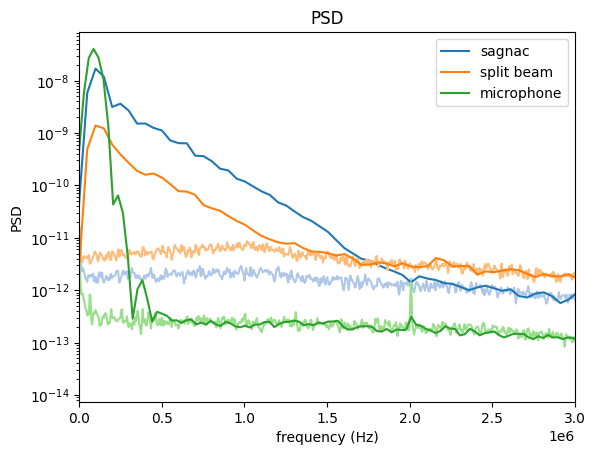

In [71]:
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, irfft
fig, ax = plt.subplots(1, 1)
cmap = plt.colormaps['tab20']

for s_i, s in enumerate(systems):
    ind = 2
    s.set_data(ind = ind)
    dat = s.get_data()[ind]
    dat.apply("lowpass", cutoff = 4e6, inplace = True)
    dat.apply("bin_average", Npts = int(dat.r / (2 * 4e6)), inplace = True)
    freq_noise, psds_noise = dat.average("PSD", tmin = 1.5e-4, tmax = 3.5e-4)
    if s.get_name()[:3] == "mic":
        freq_signal, psds_signal = dat.average("PSD", tmin = 4.14e-4, tmax = 4.48e-4)
    else:
        s.local_detrend([], ind, tmin = 0, tmax = 3.5e-4, inplace = True)
        freq_signal, psds_signal = dat.average("PSD", tmin = 4.37e-4, tmax = 4.57e-4)
    ax.plot(freq_noise, psds_noise, color = cmap.colors[2 * s_i + 1])
    ax.plot(freq_signal, psds_signal, label = s.get_name(), color = cmap.colors[2 * s_i])
    s.set_data(ind = ind)
ax.set_yscale("log")
ax.set_xlim([0, 3e6])
ax.set_title("PSD")
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("PSD")
ax.legend()
fig.savefig("PSDvsFreqStrongShot.png")
plt.show()

# BW evolution of single shot

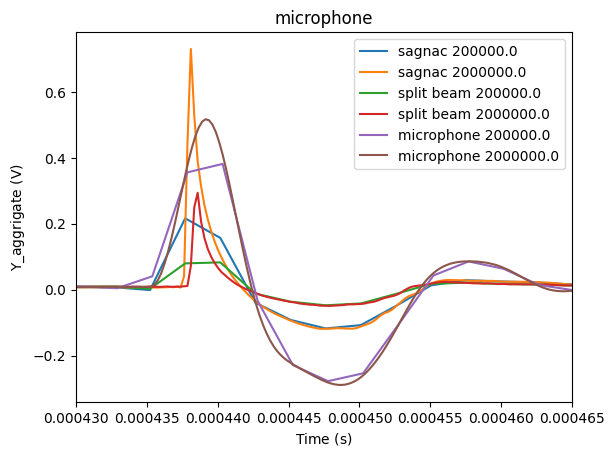

In [58]:
import matplotlib.pyplot as plt

freq_range = [2e6, 2e5]
fig, ax = plt.subplots()
for s in systems:
    ind = 0
    for freq in freq_range[::-1]:
        s.set_data(ind = ind)
        dat = s.get_data()[ind]
        if s.get_name() == "split beam":
            for c in dat.collection:
                c.x -= 0.17
        if s.get_name()[:3] == "mic":
            dat.apply("shift", tau = -2e-5, inplace = True)
        dat.apply("lowpass", cutoff = freq, inplace = True)
        dat.apply("bin_average", Npts = int(dat.r / (2 * freq)), inplace = True)
        dat.aggrigate(collection_slice = slice(1, len(dat.collection), 1))
        dat.agg.plot(ax = ax, label = s.get_name() + " " + str(freq))
    ax.set_title(s.get_name())
    ax.set_xlim([4.3e-4, 4.65e-4])
    ax.legend()
plt.show()

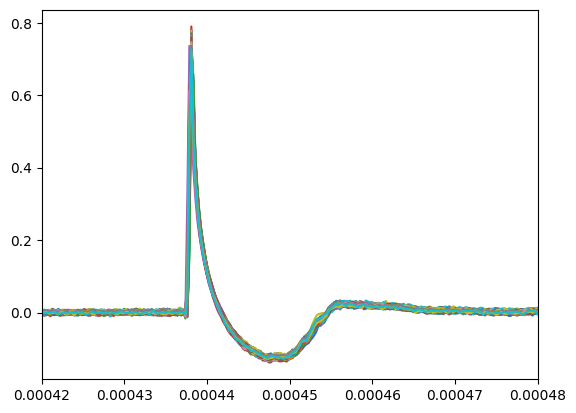

In [67]:
import matplotlib.pyplot as plt
ind = 0
s = systems[0]
fig, ax = plt.subplots()
s.local_detrend([], ind, 0, 3.5e-4, True)
for c in s.get_data()[ind].collection[1:]:
    ax.plot(c.t, c.x)
ax.set_xlim([4.2e-4, 4.8e-4])
plt.show()
s.set_data(ind = ind)